# Basic Population Simulation for Contact Tracing Data Generation

## Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from classes import Person, Location
import random, string

## Set Plot Style

In [3]:
plt.rcParams['figure.figsize'] = [12.5/2.54, 10/2.54]
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 50
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## Generics

Set the generics for the simulation. The x and y distance is used to designate the area of the simulation. The population density along with the x and y distance determines the number of people in the simulation. The sim_length is in number of days with the smallest being 1. The cell x and y values determine the granularity of the contact area, needs to divide into x and y dist. The percent infected designates the percent of infected people in the simulation. 

In [4]:
location_x_dist = 10000 #meters
location_y_dist = 10000 #meters
pop_density = 2 #people per square km
sim_length = 1 #days (set to 1 for now)
cell_x = 10 #meters
cell_y = 10 #meters
percent_infected = 1 #percent

## Random Variable Parameters

The random variables in the simulation determine how many places people visit in a day and the amount of movement around that position.

In [5]:
#normal dist for num positions per day
pos_mu = 5
pos_sigma = 2

#normal dist for position variation in meters
pos_var_mu = 0 #fixed
pos_var_sigma = 50

## Generated Parameters

The generated values are based on the simulation generics that are defined 

In [6]:
area = location_x_dist*location_y_dist
cell_area = cell_x*cell_y
num_people = pop_density*(area//1000000)
num_infected = int(num_people*(percent_infected/100))
print('Number of People in Sim:', num_people)
print('Number Infected:', num_infected)

Number of People in Sim: 200
Number Infected: 2


## Sim Loop

The main loop of the simulation that is used to generate population movement based on the generics and random variable distributions.

In [7]:
people = []
min_per_day = 1440

for day in range(sim_length):
    for i in range(num_people):
        #determine number of positions
        positions = abs(int(np.random.normal(pos_mu, pos_sigma, 1)))
        if positions == 0:
            positions = 1
    
        #randomly assign integer time at each position
        random_vals = np.random.randint(1,100,positions)
        randoms_sum = sum(random_vals)
        position_times = (random_vals/randoms_sum)*min_per_day
        #print(position_times)
        for m in range(positions):
            position_times[m] = int(position_times[m])
        diff = min_per_day - sum(position_times)
        position_times[0] = position_times[0] + diff
        #print(position_times)
        # print(sum(position_times))
    
        #create position locations
        locations = []
        time = 0
        for l in range(positions):
            x = np.random.randint(0,location_x_dist)
            y = np.random.randint(0,location_y_dist)
            loc = Location(day, time, x, y)
            locations.append(loc)
            time = time + 1
        
            for r in range(int(position_times[l])-1):
                x_var = int(np.random.normal(pos_var_mu, pos_var_sigma, 1))
                y_var = int(np.random.normal(pos_var_mu, pos_var_sigma, 1))
                loc = Location(day, time, x+x_var, y+y_var)
                locations.append(loc)
                time = time + 1
    
        if len(people) < i+1:
            person = Person(i, locations)
            people.append(person)
        else:
            people[i].locs.extend(locations)

### Plot the point cloud of all people

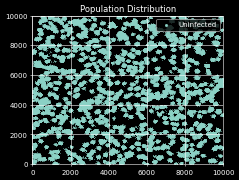

In [8]:
x = []
y = []
for person in people:
    for loc_i in person.locs:
        x.append(loc_i.pos[0])
        y.append(loc_i.pos[1])
    
plt.scatter(x, y, s=.1, label='Uninfected')
plt.axis([0, location_x_dist, 0, location_y_dist])
plt.grid()
plt.legend(loc="upper right", markerscale=10)
plt.title('Population Distribution')
plt.show()

### Check time to make sure its linear over multiple days

In [9]:
time_t = []
for loc_i in people[0].locs:
    time_t.append(loc_i.time)
#plt.plot(range(min_per_day*sim_length), time_t)
#plt.show()

## Create Algorithm Grid

The grid is filled using a counting pattern to provide unique id for each grid cell

In [10]:
num_cells = (area//cell_area)
print('Number of unique cells:',num_cells)

Number of unique cells: 1000000


In [11]:
cell_ids = []
for d in range(sim_length):
    cell_matrix = np.arange(num_cells*d,num_cells*(d+1)).reshape(location_x_dist//cell_x, location_y_dist//cell_y)
    cell_ids.append(cell_matrix)

### Apply cell ids to locations invalidating out of area positions

A location position can fall outside the grid area due to position variation random variable. These positions are marked with -1 to denote that the cell is invalid.

In [12]:
for person in people:
    for loc in person.locs:
        cell_x_index = int(loc.pos[0]/cell_x)
        cell_y_index = int(loc.pos[1]/cell_y)
        day = loc.day
        if loc.pos[0] < 0 or loc.pos[1] < 0:
            cell_id = -1
            #print(loc.pos[0], loc.pos[1])
        else:
            try:
                cell_id = cell_ids[day][cell_y_index][cell_x_index]
            except:
                cell_id = -1
                #print(loc.pos[0], loc.pos[1])
        loc.cell = cell_id

In [13]:
#Check for any un labled cells
for person in people:
    for loc in person.locs:
        if loc.cell == None:
            print(loc.cell, loc.pos)

## Select Infected People

In [14]:
infected = []
for i in range(num_infected):
    temp_index = int(np.random.randint(0,num_people,1))
    people[temp_index].infected = True
    infected.append(people[temp_index])
    people.pop(temp_index)
    #print(people[int(temp_index)].id_num)

## Plot the Infected vs Population

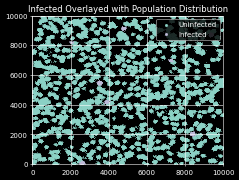

In [15]:
x = []
y = []
xi = []
yi = []
for person in people:
    for loc_i in person.locs:
        x.append(loc_i.pos[0])
        y.append(loc_i.pos[1])

for person in infected:
    for loc_i in person.locs:
        xi.append(loc_i.pos[0])
        yi.append(loc_i.pos[1])
    
plt.scatter(x, y, s=.1, label='Uninfected')
plt.scatter(xi, yi, c=colors[2], s=.1, label='Infected')
plt.axis([0, location_x_dist, 0, location_y_dist])
plt.grid()
plt.legend(loc="upper right", markerscale=10)
plt.title('Infected Overlayed with Population Distribution')
plt.show()

## Check Matching Hits for Population

In [16]:
infected_locs = []
for person in infected:
    infected_locs.extend(person.locs)
    
infected_cells = []
for loc in infected_locs:
    infected_cells.append(loc.cell)
    #print(loc.cell)
        
print('Number of infected locations:', len(infected_locs))
print('Number of infected Cells:', len(infected_cells))

for person in people:
    for loc in person.locs:
        if loc.cell != -1:
            if loc.cell in infected_cells:
                temp_count = infected_cells.count(loc.cell)
                for i in range(temp_count):
                    person.contacts.append(loc)
                #print(loc.pos[0], loc.pos[1], loc.cell)           

Number of infected locations: 2880
Number of infected Cells: 2880


### Plot the contact areas

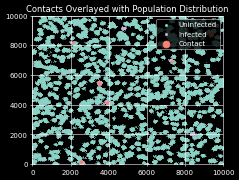

In [17]:
xc = []
yc = []
for person in people:
    if len(person.contacts) > 0:
        for loc_con in person.contacts:
            xc.append(loc_con.pos[0])
            yc.append(loc_con.pos[1])
            #print(loc_con.pos[0], loc_con.pos[1])
        
plt.scatter(x, y, s=.1, label='Uninfected')
plt.scatter(xi, yi, c=colors[2], s=.1, label='Infected')
plt.scatter(xc, yc, c=colors[3], s=1, label='Contact')
plt.axis([0, location_x_dist, 0, location_y_dist])
plt.grid()
plt.legend(loc="upper right", markerscale=10)
plt.title('Contacts Overlayed with Population Distribution')
plt.show()

### Print Statistics

In [18]:
per_person_num_contacts = []
for person in people:
    if len(person.contacts) > 0:
        per_person_num_contacts.append(len(person.contacts))
        
average_contact_time = np.mean(per_person_num_contacts)
median_contact_time = np.median(per_person_num_contacts)
print('Average Contact time:', average_contact_time, 'mins')
print('Median Contact time:', median_contact_time, 'mins')

num_people_in_contact = len(per_person_num_contacts)
percent_of_pop_contact = (num_people_in_contact/num_people)*100
print('Percent of Population in Contact:', percent_of_pop_contact, '%')

Average Contact time: 43.333333333333336 mins
Median Contact time: 9.0 mins
Percent of Population in Contact: 4.5 %


## Save Population Data

In [19]:
f1 = 'clear_population.pickle'
of1 = open(f1,'wb')
pickle.dump(people,of1)
of1.close()

f2 = 'infected_population.pickle'
of2 = open(f2,'wb')
pickle.dump(infected,of2)
of2.close()